In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import sys
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, LeaveOneOut
from sklearn.feature_selection import SequentialFeatureSelector

from get_data import *

### Data load

In [36]:
ds = get_data_model_v1()
ds.info()

Database object created
<class 'pandas.core.frame.DataFrame'>
Int64Index: 684 entries, 0 to 683
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  684 non-null    int64  
 1   titulo              684 non-null    object 
 2   descripcion         672 non-null    object 
 3   extra_info          680 non-null    object 
 4   n_habitaciones      684 non-null    int64  
 5   tamano              684 non-null    int64  
 6   precio              684 non-null    float64
 7   municipio           684 non-null    object 
 8   n_banos             677 non-null    float64
 9   n_plazas_garaje     677 non-null    float64
 10  direccion           677 non-null    object 
 11  landmarks_cercanos  677 non-null    object 
 12  piscina             684 non-null    bool   
 13  valoracion          677 non-null    float64
 14  direccion_x         501 non-null    float64
 15  direccion_y         501 non-null 

c:\Users\ivan\Desktop\Coding\corunaRealEstateMarket\bd.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.connection)


In [37]:
object_columns = ds.select_dtypes(include=['object']).columns.tolist()
ds_object = ds[object_columns]
ds_object.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684 entries, 0 to 683
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   titulo              684 non-null    object
 1   descripcion         672 non-null    object
 2   extra_info          680 non-null    object
 3   municipio           684 non-null    object
 4   direccion           677 non-null    object
 5   landmarks_cercanos  677 non-null    object
dtypes: object(6)
memory usage: 37.4+ KB


In [38]:
cols = ds.columns
cols_exclude = ['id', 'titulo', 'descripcion', 'extra_info', 'direccion', 'landmarks_cercanos', 'municipio', 'direccion_x', 'direccion_y']
cols_check_nas = ['n_banos', 'n_plazas_garaje', 'valoracion']
for col in cols_check_nas:
    if sum(ds[col]==-1)/len(ds) > 0.25:
        print(f'Column {col} has more than 20% of missing values.')
        cols_exclude.append(col)

cols_model = [col for col in cols if col not in cols_exclude]

#convert int and bool columns to float
for col in cols:
    if ds[col].dtype == 'int64':
        ds[col] = ds[col].astype('float64')
    elif ds[col].dtype == 'object':
        cols_exclude.append(col)
    elif ds[col].dtype == 'bool':
        ds[col] = ds[col].astype('float64')

Column n_banos has more than 20% of missing values.
Column n_plazas_garaje has more than 20% of missing values.


### Data exploration

Correlaciones

In [93]:
abs(x.corrwith(y)).sort_values(ascending=False)

tamano            0.658472
es_casa           0.503725
n_habitaciones    0.434187
oleiros           0.254257
sin_ascensor      0.230452
amueblado         0.224169
vistas            0.199311
piscina           0.195646
estudiantes       0.142985
pib_capita        0.128771
playa             0.127236
coruna            0.113026
densidad          0.100993
art_berg_camb     0.063328
profesores        0.041059
balcon            0.029128
trastero          0.029083
parking           0.024817
vacacional        0.019004
valoracion        0.016406
dtype: float64

### Data visualization

sns.set(style="whitegrid")  # Set the style of the plot

# Create a scatter plot with a regression line
sns.lmplot(x="x", y="y", data=df)

# Show the plot
plt.show()

### Deal with NAs

In [39]:
for col in cols_check_nas:
    ds[col] = ds[col].fillna(np.mean(ds[col]))

### Municipios column

In [40]:
ds['coruna'] = ds["municipio"].apply(lambda x: 1.0 if 'coru' in x else 0.0)
ds['oleiros'] = ds["municipio"].apply(lambda x: 1.0 if 'oleiros' in x else 0.0)
ds['art_berg_camb'] = ds["municipio"].apply(lambda x: 1.0 if ('artei' in x or 'berg' in x or 'cambr' in x) else 0.0)

cols_model.append('coruna')
cols_model.append('oleiros')
cols_model.append('art_berg_camb')

### Data split

In [226]:
x = ds[cols_model].drop('precio', axis=1)
y = ds['precio']

# slit data into train and val
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [227]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684 entries, 0 to 683
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   n_habitaciones  684 non-null    float64
 1   tamano          684 non-null    float64
 2   piscina         684 non-null    float64
 3   valoracion      684 non-null    float64
 4   densidad        684 non-null    float64
 5   pib_capita      684 non-null    float64
 6   parking         684 non-null    float64
 7   estudiantes     684 non-null    float64
 8   playa           684 non-null    float64
 9   balcon          684 non-null    float64
 10  trastero        684 non-null    float64
 11  vacacional      684 non-null    float64
 12  vistas          684 non-null    float64
 13  sin_ascensor    684 non-null    float64
 14  profesores      684 non-null    float64
 15  amueblado       684 non-null    float64
 16  es_casa         684 non-null    float64
 17  coruna          684 non-null    flo

### Model: Linear reg

In [228]:
def train_model(x,y, model, n_splits=5, n_repeats=5):
    return_val = []
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)
    rkf.get_n_splits(x, y)
    for i, (train_index, val_index) in enumerate(rkf.split(x)):
        x_train = x.iloc[train_index]
        y_train = y.iloc[train_index]
        x_val = x.iloc[val_index]
        y_val = y.iloc[val_index]
        model.fit(x_train, y_train)
        y_train_pred = model.predict(x_train)
        y_val_pred = model.predict(x_val)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_val = mean_absolute_error(y_val, y_val_pred) 
        return_val.append({'rmse_train': rmse_train, 'rmse_val': rmse_val, 'mae_train': mae_train, 'mae_val': mae_val})
    return return_val

#### Linear reg

Repeated CV

In [229]:
trainings = train_model(x,y, LinearRegression(), n_splits=5, n_repeats=5)
rmse_train = [x['rmse_train'] for x in trainings]
rmse_val = [x['rmse_val'] for x in trainings]
mae_train = [x['mae_train'] for x in trainings]
mae_val = [x['mae_val'] for x in trainings]

print(f'RMSE train:\t mean {np.mean(rmse_train):.2f}\t std {np.std(rmse_train):.2f}')
print(f'RMSE val:\t mean {np.mean(rmse_val):.2f}\t std {np.std(rmse_val):.2f}')
print("")
print(f'MAE train:\t mean {np.mean(mae_train):.2f}\t std {np.std(mae_train):.2f}')
print(f'MAE val:\t mean {np.mean(mae_val):.2f}\t std {np.std(mae_val):.2f}')

RMSE train:	 mean 368.20	 std 15.05
RMSE val:	 mean 393.01	 std 56.39

MAE train:	 mean 219.17	 std 9.21
MAE val:	 mean 233.38	 std 22.24


LeaveOneOut

In [230]:
trainings = train_model(x,y, LinearRegression(), n_splits=len(x), n_repeats=1)
rmse_train = [x['rmse_train'] for x in trainings]
mae_train = [x['mae_train'] for x in trainings]
errors_val = [x['mae_val'] for x in trainings]
rmse_val = np.sqrt(np.power(errors_val, 2).mean())
mae_val = np.mean(errors_val)

print(f'RMSE train:\t mean {np.mean(rmse_train):.2f}\t std {np.std(rmse_train):.2f}')
print(f'RMSE val:\t mean {np.mean(rmse_val):.2f}\t std {np.std(errors_val):.2f}')
print("")
print(f'MAE train:\t mean {np.mean(mae_train):.2f}\t std {np.std(mae_train):.2f}')
print(f'MAE val:\t mean {np.mean(mae_val):.2f}\t std {np.std(errors_val):.2f}')

RMSE train:	 mean 371.24	 std 1.23
RMSE val:	 mean 389.58	 std 314.62

MAE train:	 mean 220.01	 std 0.64
MAE val:	 mean 229.75	 std 314.62


#### Variable selection

In [224]:
def get_step_score(current_cols, new_col, x, y, model):
    cols = current_cols + [new_col]
    trainings = train_model(x[cols],y, model)
    rmse_train = [x['rmse_train'] for x in trainings]
    rmse_train = np.mean(rmse_train)
    rmse_val = [x['rmse_val'] for x in trainings]
    rmse_val = np.mean(rmse_val)
    return rmse_train, rmse_val

current_cols = []
scores_train = []
scores_val = []
cols = []
all_columns = cols_model[:]
all_columns.remove('precio')

for k in range(len(all_columns)-1):
    best_col = None
    best_score_training = 1e20
    best_score_val = 1e20
    best_model = None
    for col in set(all_columns)-set(current_cols):
        score_training, score_val = get_step_score(current_cols, col, x, y, LinearRegression())
        if score_training < best_score_training:
            best_score_training = score_training
            best_score_val = score_val
            best_col = col
    current_cols.append(best_col)
    scores_train.append(best_score_training)
    scores_val.append(best_score_val)
    cols.append(current_cols[:])
    print(f'Best column: {best_col}\t score training:{best_score_training:.2f}\t score_val:{score_val:.2f}')

Best column: tamano	 score training:297.02	 score_val:385.06
Best column: vistas	 score training:291.11	 score_val:287.92
Best column: sin_ascensor	 score training:286.76	 score_val:285.57
Best column: n_habitaciones	 score training:283.49	 score_val:284.90
Best column: playa	 score training:280.31	 score_val:283.61
Best column: es_casa	 score training:278.71	 score_val:280.48
Best column: vacacional	 score training:277.60	 score_val:283.38
Best column: parking	 score training:276.41	 score_val:277.76
Best column: amueblado	 score training:275.63	 score_val:280.87
Best column: estudiantes	 score training:275.28	 score_val:281.40
Best column: balcon	 score training:274.68	 score_val:279.73
Best column: valoracion	 score training:274.47	 score_val:282.84
Best column: piscina	 score training:274.52	 score_val:281.26
Best column: art_berg_camb	 score training:274.26	 score_val:283.41
Best column: profesores	 score training:274.24	 score_val:284.97
Best column: pib_capita	 score training:27

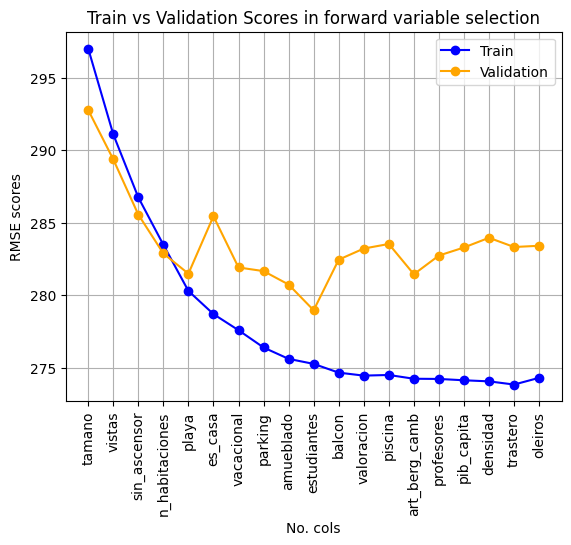

In [225]:
idx = list(range(len(current_cols)))
plt.plot(idx, scores_train, marker='o', linestyle='-', color='blue', label='Train')
plt.plot(idx, scores_val, marker='o', linestyle='-', color='orange', label='Validation')

plt.xlabel('No. cols')
plt.ylabel('RMSE scores')
plt.title('Train vs Validation Scores in forward variable selection')
plt.xticks(idx, current_cols)  # Use column names as x-axis labels
#in vertical
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()

#### Usando solo n_habitaciones y tamaño

In [217]:
ds_aux = ds[ds['municipio'].str.contains('oru')]
# ds_aux = ds
x = ds_aux[cols_model]
x = x.drop('precio', axis=1)
y = ds_aux['precio']

trainings = train_model(x,y, LinearRegression(), n_splits=5, n_repeats=50)
rmse_train = [x['rmse_train'] for x in trainings]
rmse_val = [x['rmse_val'] for x in trainings]
mae_train = [x['mae_train'] for x in trainings]
mae_val = [x['mae_val'] for x in trainings]

print(f'RMSE train:\t mean {np.mean(rmse_train):.2f}\t std {np.std(rmse_train):.2f}')
print(f'RMSE val:\t mean {np.mean(rmse_val):.2f}\t std {np.std(rmse_val):.2f}')
print("")
print(f'MAE train:\t mean {np.mean(mae_train):.2f}\t std {np.std(mae_train):.2f}')
print(f'MAE val:\t mean {np.mean(mae_val):.2f}\t std {np.std(mae_val):.2f}')

RMSE train:	 mean 274.10	 std 16.01
RMSE val:	 mean 283.43	 std 57.79

MAE train:	 mean 174.55	 std 6.33
MAE val:	 mean 183.31	 std 18.55


### Model: Lasso reg

In [144]:
lambda_vals = [0.1, 0.5, 1, 2, 4, 5, 7, 9 ,10, 15, 20, 30, 40, 50, 100]
scores_record= []
models = []

for val in lambda_vals:
    model = linear_model.Lasso(alpha=val, max_iter=10000, tol=0.1)

    rkf = RepeatedKFold(n_splits=5, n_repeats=10)
    scores = cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_error', cv=rkf)
    scores = np.sqrt(np.abs(scores))

    scores_mean = np.mean(scores)
    scores_record.append(scores_mean)

    model.fit(x_train, y_train)
    models.append(model)
    cols_selected = x_train.columns[model.coef_ > 0.0001]
    print("lambda val: ", val, '\t', "RMSE: ", scores_mean, '\t', len(cols_selected), cols_selected.to_list())

c:\Users\ivan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.537e+07, tolerance: 1.597e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\ivan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.230e+07, tolerance: 1.427e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\ivan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

lambda val:  0.1 	 RMSE:  413.8495747463398 	 10 ['tamano', 'piscina', 'parking', 'playa', 'balcon', 'vacacional', 'vistas', 'es_casa', 'coruna', 'oleiros']
lambda val:  0.5 	 RMSE:  410.7342228250872 	 10 ['tamano', 'piscina', 'densidad', 'parking', 'playa', 'balcon', 'vacacional', 'vistas', 'es_casa', 'oleiros']
lambda val:  1 	 RMSE:  411.41486003533197 	 10 ['tamano', 'piscina', 'densidad', 'parking', 'playa', 'balcon', 'vacacional', 'vistas', 'es_casa', 'oleiros']
lambda val:  2 	 RMSE:  409.09525468920583 	 10 ['tamano', 'piscina', 'densidad', 'parking', 'playa', 'balcon', 'vacacional', 'vistas', 'es_casa', 'oleiros']
lambda val:  4 	 RMSE:  411.73706143222824 	 7 ['tamano', 'piscina', 'densidad', 'playa', 'vistas', 'es_casa', 'oleiros']
lambda val:  5 	 RMSE:  414.6510360584561 	 6 ['tamano', 'densidad', 'playa', 'vistas', 'es_casa', 'oleiros']
lambda val:  7 	 RMSE:  410.91916932503113 	 6 ['tamano', 'densidad', 'playa', 'vistas', 'es_casa', 'oleiros']
lambda val:  9 	 RMSE:  4

In [15]:
model = LinearRegression()
model.fit(x_train, y_train)
r2_scored = model.score(x_test, y_test)
print("R2 Scored: ", r2_scored)

R2 Scored:  0.3828136716884596
